In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import torch
import torchaudio
import numpy as np
from torchaudio import functional as F
from torchaudio.utils import download_asset
from IPython import display
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.HERB.algorithm import dereverberate
from src.LP.algorithm import LP_dereverberation
from src.WPE.wpe import wpe_dereverberation

## Sample Data

In [3]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
sr = 16000

In [4]:
rir, rir_sr = torchaudio.load(SAMPLE_RIR)
rir = rir[:, int(rir_sr * 1.01) : int(rir_sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)
rir = torchaudio.transforms.Resample(rir_sr, sr)(rir)

display.Audio(rir, rate=sr)

In [5]:
speech, speech_sr = torchaudio.load(SAMPLE_SPEECH)
speech = torchaudio.transforms.Resample(speech_sr, sr)(speech)
display.Audio(speech, rate=sr)

In [6]:
augmented = F.fftconvolve(speech, rir)
display.Audio(augmented, rate=sr)

In [11]:
augmented = augmented.to(torch.float64).numpy().sum(axis=0)
augmented = augmented / np.abs(augmented).max()

## Applying HERB

In [27]:
#result = get_audio_hat(augmented, augmented)
result,  spectr_filter = dereverberate(augmented, steps=3, n_repeats=0)

In [13]:
result

array([-0.00372965, -0.00371926, -0.00371198, ..., -0.00034204,
       -0.00034416, -0.00034615])

In [14]:
display.Audio(result / np.abs(result).max(), rate=sr)

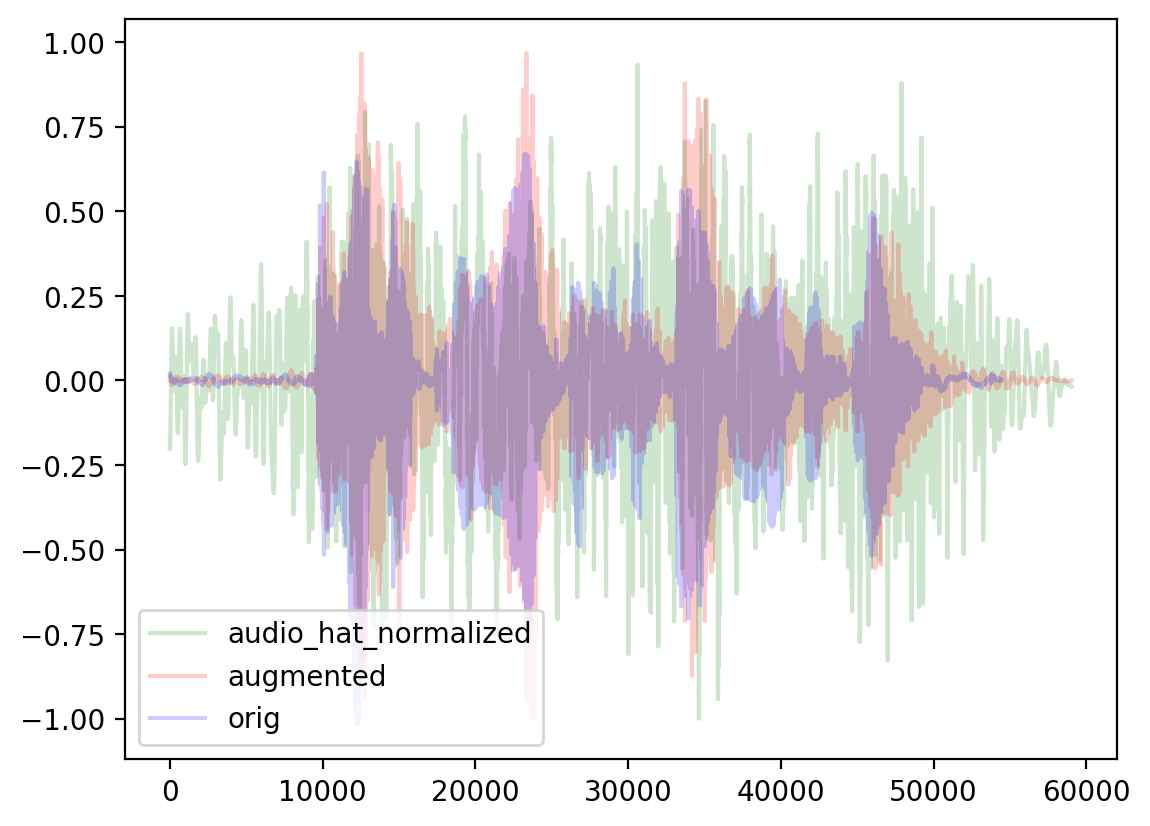

In [15]:
#plt.plot(result, color="blue", alpha=0.2, label="audio_hat")
plt.plot(result / np.abs(result).max(), color="green", alpha=0.2, label="audio_hat_normalized")
plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")
plt.legend()

##### T60

In [16]:
from pyroomacoustics.experimental.rt60 import measure_rt60

In [17]:
rir_numpy = rir[0].numpy()
rir_filtered = ss.convolve(rir_numpy, spectr_filter, mode="same")

(0.49925, 0.28974999999999995)

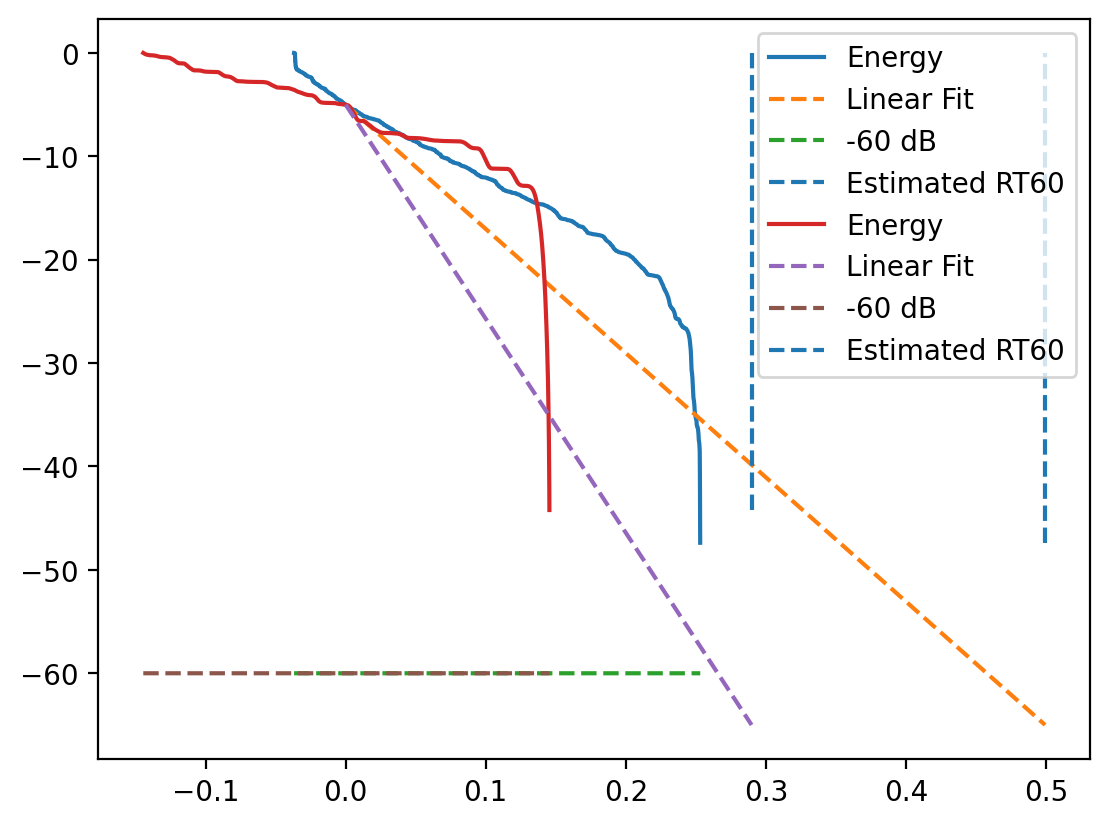

In [18]:
T60 = measure_rt60(rir_numpy, fs=16000, decay_db=30, plot=True)
filtered_T60 = measure_rt60(rir_filtered, fs=16000, decay_db=30, plot=True)

T60, filtered_T60

## Applying LP


In [19]:
Lp_derev, LP_filt = LP_dereverberation(augmented, mu = 3e-9, nIterations=500)

In [20]:
display.Audio(Lp_derev, rate=sr)    

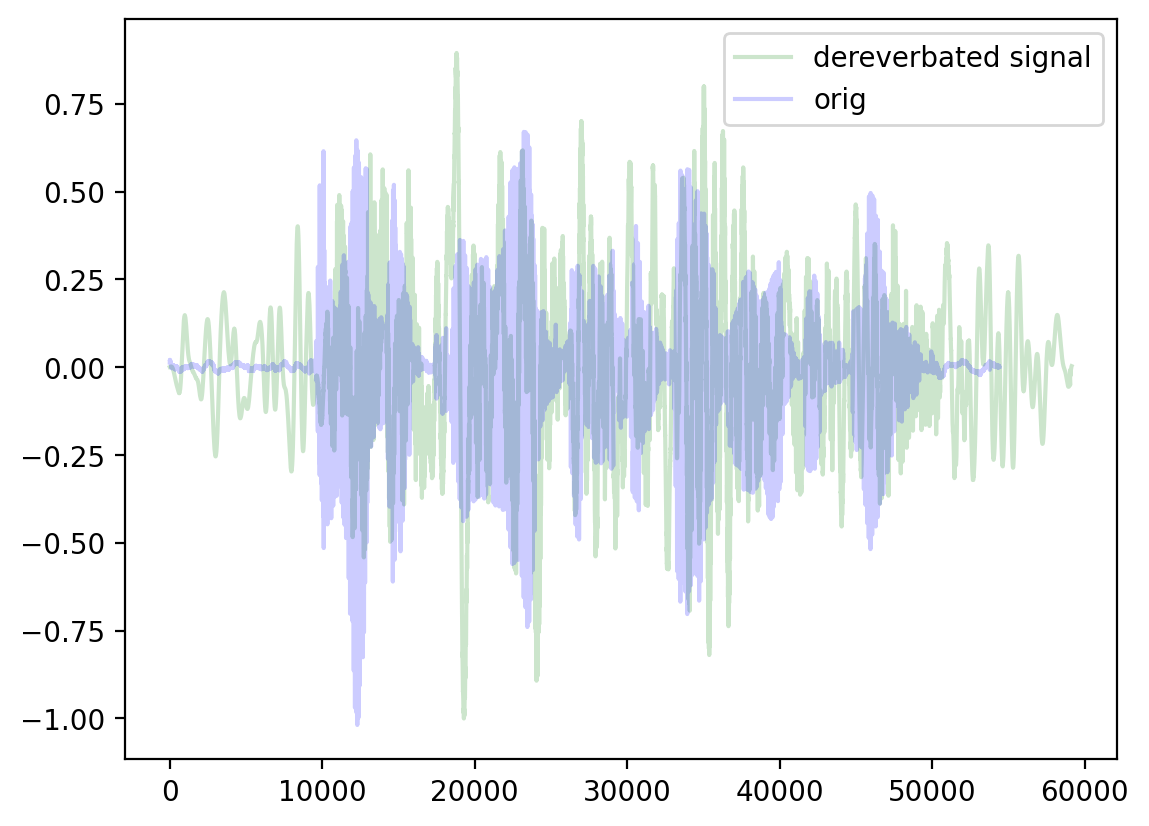

In [21]:
plt.plot(Lp_derev / np.abs(Lp_derev).max(), color="green", alpha=0.2, label="dereverbated signal")
#plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")

plt.legend()

#### T60 for LP

(0.7029375, 0.3063749999999999)

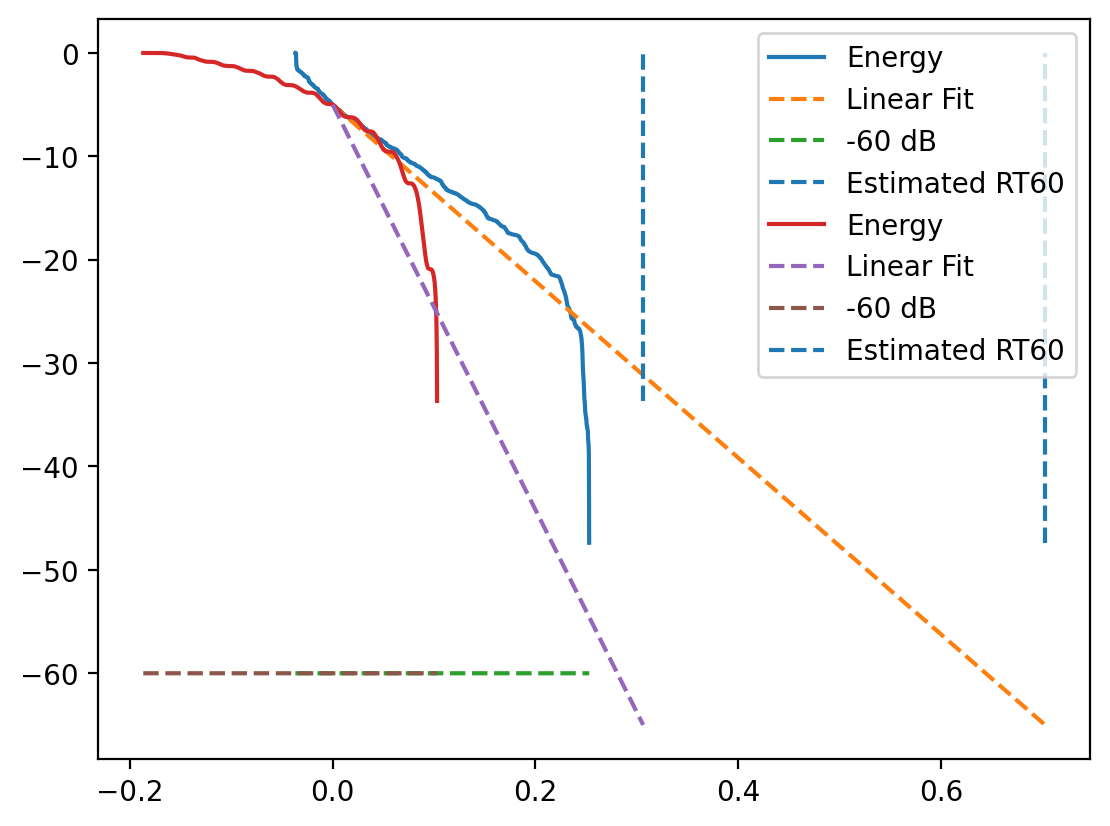

In [22]:
filtered_rir_lp = ss.lfilter(LP_filt, 1, rir_numpy)

T60 = measure_rt60(rir_numpy, fs=16000, decay_db=20, plot=True)
LP_filtered_T60 = measure_rt60(filtered_rir_lp, fs=16000, decay_db=20, plot=True)

T60, LP_filtered_T60

## Applying WPE

In [23]:
augmented.shape
# make this a 2D array
augmented_nara = augmented.reshape(1, -1)
augmented_nara.shape

(1, 59039)

In [24]:
wpe_dereverbated = wpe_dereverberation(augmented_nara)

In [25]:
display.Audio(wpe_dereverbated, rate=sr)

#### T60 for WPE

WPE does not return inverse filter, so we do not actually calculate t60 for WPE.

In [26]:
# Calculating RT60
# T60 = measure_rt60(speech, fs=16000, decay_db=20, plot=True)
# wpe_filtered_T60 = measure_rt60(wpe_dereverbated, fs=16000, decay_db=20, plot=True)
# T60, wpe_filtered_T60